In [1]:
import torch
import sys
import numpy as np
import itertools
import models
from models import ConvLSTM
from dataset import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import argparse
import time
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ['CUDA_VISIBLE_DEVICES'] = '2'


In [2]:
from flickerfusion.utils import *
from flickerfusion.attacks import LinfAttack, L2Attack
from advertorch.utils import NormalizeByChannelMeanStd

In [3]:
model_path = 'model_checkpoints/model_nodecay_30.pth'

In [4]:
device = "cuda"

In [5]:
!nvidia-smi

Mon Jun  5 13:47:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 20%   41C    P0    61W / 250W |      0MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:09:00.0 Off |                  N/A |
| 22%   40C    P0    59W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [6]:
# Define network
model = ConvLSTM(
    num_classes=101,
    latent_dim=512,
    lstm_layers=1,
    hidden_dim=1024,
    bidirectional=True,
    #attention=True,
)
model.load_state_dict(torch.load(model_path))
model = torch.nn.Sequential(
    NormalizeByChannelMeanStd(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    model
)
model = model.to(device)
model.eval()

Sequential(
  (0): NormalizeByChannelMeanStd(mean=tensor([0.4850, 0.4560, 0.4060], device='cuda:0'), std=tensor([0.2290, 0.2240, 0.2250], device='cuda:0'))
  (1): ConvLSTM(
    (encoder): Encoder(
      (feature_extractor): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(6

In [7]:
from torchvision import transforms
from PIL import Image

# Get videos with all frames, as a result, batch_size should be 1
test_dataset = Dataset(
    dataset_path="data/UCF-101-frames/",
    split_path="data/ucfTrainTestlist",
    split_number=1,
    input_shape=(3,224,224),
    sequence_length=100,
    training=True,
    transform = transforms.Compose(
        [
            transforms.Resize((224,224), Image.BICUBIC),
            transforms.ToTensor(),
        ]
    )
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

/home/sangwooji/miniconda3/envs/colorfusion/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [8]:
net = model

In [9]:
config = {}
config['row_mask_rate'] = 0
config['row_mask_pad'] = 0
config['rand_weight'] = 0
config['rand_base'] = 0
config['save_iter'] = 0
config['coeff_xy'] = 1
config['nb_proj'] = 1
aug = None

In [10]:
class LRGBLum0Attack():
    """
    LRGB attack in Luminance 0 plane
    """        
    def perturb(self, net, images, labels, config, device, targeted=False, 
                verbose=False, aug=None):
        # For LSTM backward available
        torch.backends.cudnn.enabled = True
        net.eval()
        net[1].lstm.train()
        batch_size = 1        

        # adv_perturbation: lrgb [224, 224, 2]  
        input_size = 224
        adv_perturbation = torch.zeros((input_size,input_size,2)).to(device)
        adv_perturbation.requires_grad = True
        expand_to_lrgb = torch.Tensor([[1, 0],[-0.2126/0.7152, -0.0722/0.7152],[0,1]]).T.to(device)

        mask_range = input_size
        mask_size = int(mask_range * config['row_mask_rate'])
        t = torch.arange(0, mask_range, device=device).repeat(batch_size,1)
        pad = config['row_mask_pad']
        
        loss_sum = 0
        save_iter = config['save_iter']
        coeff_xy = config['coeff_xy']
        nb_proj = config['nb_proj']
        if coeff_xy >= 0:
            mseloss = torch.nn.MSELoss()
            
        for i in range(self.nb_iter):
            # sample
            with torch.no_grad():
                sequence_length = 40
                video_len = len(images[0])
                sample_interval = np.random.randint(1, video_len // sequence_length + 1)
                start_i = np.random.randint(0, video_len - sample_interval * sequence_length + 1)
                adv_indices = []
                for rand_idx in range(start_i, start_i + sequence_length*sample_interval, sample_interval):
                    adv_indices.append(rand_idx)
                adv_indices = torch.tensor(adv_indices)

                # sampled frames of source video
                video = images[0][adv_indices]
                video_lrgb = rgb2lrgb(video)
            net.zero_grad()
            net[1].lstm.reset_hidden_state()
            
            # expand perturbation
            l_perturbation = torch.matmul(adv_perturbation,expand_to_lrgb).permute(2,0,1)
                
            # Random intensity
            weight = torch.rand(1).to(device)
            l_perturbation = (weight*config['rand_weight']+config['rand_base'])*l_perturbation
            
            # Row masking
            start_row = torch.randint(low=pad, high=mask_range-mask_size-pad, \
                                      size=(batch_size,1), device=device)
            mask = t.ge(start_row) & t.lt(start_row+mask_size)
            l_perturbation[mask.reshape(1,input_size,1).repeat(3,1,input_size)] = 0

            # add perturbation
            p_proj = project_perturbation(video_lrgb, l_perturbation, nb_proj)

            temp = video_lrgb + p_proj
            p_plus = torch.clamp(temp, 0, 1)
            idx_plus = p_plus != temp
            p_plus = p_plus - video_lrgb

            temp = video_lrgb - p_proj
            p_minus = torch.clamp(temp, 0, 1)
            idx_minus = p_minus != temp
            p_minus = video_lrgb - p_minus

            p_clipped = torch.where(p_plus.abs() > p_minus.abs(), p_minus, p_plus)
            p_clipped = torch.where(idx_plus | idx_minus, p_clipped, p_proj)
            l_perturbation = p_clipped
            
            # plus, minus, mixed
            adv_minus = lrgb2rgb(torch.clamp(video_lrgb - l_perturbation, 0, 1))
            adv_plus = lrgb2rgb(torch.clamp(video_lrgb + l_perturbation, 0, 1))

            adv_video = []
            for video_idx, src_idx in enumerate(adv_indices):
                if src_idx % 2 == 0:
                    adv_video.append(adv_plus[video_idx])
                else:
                    adv_video.append(adv_minus[video_idx])
            adv_video = torch.stack(adv_video)
            
#             print ((adv_video - video).abs().mean())
            if aug is not None:
                adv_aug = aug(adv_video)
            else:
                adv_aug = adv_video
            
            # unsqueeze for conforming a batch
            outputs = net(adv_aug.unsqueeze(0))
            _, pred = outputs.max(1)
            
            loss_ce = self.loss_fn(outputs, labels)
            
            if coeff_xy >= 0:
                video_xyY = rgb2xyY(video)
                plus_xyY = rgb2xyY(adv_plus)
                minus_xyY = rgb2xyY(adv_minus)
                merged_xyY = (plus_xyY + minus_xyY) / 2
                loss_xy = mseloss(xyY2rgb(merged_xyY), video)
                
            loss = loss_ce + coeff_xy * loss_xy
            loss.backward()

            grad = self._get_perturb(adv_perturbation.grad.detach())
            print (adv_perturbation.grad.abs().sum())
            if targeted:
                adv_perturbation.data = adv_perturbation.data - self.eps_iter * grad
            else:
                adv_perturbation.data = adv_perturbation.data + self.eps_iter * grad
            adv_perturbation.data = self._projection(adv_perturbation.data, 1)
            adv_perturbation.grad.data.zero_()
            
            print ("iter %d: pred: %d l_ce %.5f, l_xy %.5f, loss %.5f" % \
                   (i, pred.item(), loss_ce.item(), coeff_xy*loss_xy.item(), loss.item()), end='\n')
            loss_sum += loss.item()
                
#             if (i+1) % save_iter == 0:
#                 file_name = '%s_%d.npy' % (config['file_name'], (i+1))
#                 np.save(config['file_dir'] + file_name, torch.matmul(adv_perturbation,expand_to_lrgb).permute(0,3,1,2).detach().cpu())
#                 print (datetime.datetime.now(), \
#                        'save the perturbation at %dth iterations' % (i+1))
                
#         file_name = '%s_%d.npy' % (config['file_name'], (i+1))
#         np.save(config['file_dir'] + file_name, torch.matmul(adv_perturbation,expand_to_lrgb).permute(0,3,1,2).detach().cpu())
#         print (datetime.datetime.now(), \
#                'save the perturbation at %dth iterations' % (i+1))
        return torch.matmul(adv_perturbation,expand_to_lrgb).permute(2,0,1).detach()

In [11]:
# Attack base class
class LinfAttack():
    def _rand_init(self, image):
        #     np.random.uniform(low=-self.eps, high=self.eps, size=image.shape)
        return image + torch.zeros_like(image).uniform_(-self.eps, self.eps)
    def _get_perturb(self, grad):
        return torch.sign(grad)
    def _projection(self, perturbation, budget):
        return torch.clamp(perturbation, -budget, budget)
    
class LinfLRGBLum0Attack(LRGBLum0Attack, LinfAttack):
    def __init__(self, loss_fn, eps, nb_iter, eps_iter, 
                 rand_init, clip_min, clip_max):
        self.loss_fn = loss_fn
        self.eps = eps
        self.nb_iter = nb_iter
        self.eps_iter = eps_iter
        self.rand_init = rand_init
        self.clip_min = clip_min
        self.clip_max = clip_max

In [29]:
attack = LinfLRGBLum0Attack(torch.nn.CrossEntropyLoss(), eps=0.3, nb_iter=30, eps_iter=0.01, rand_init=False, clip_min=0, clip_max=0)

In [30]:
idx = 300
images, labels =  test_dataset.__getitem__(idx)
images = images.unsqueeze(0).to(device)
labels = torch.tensor([labels]).to(device)

In [31]:
config = {}
config['row_mask_rate'] = 0
config['row_mask_pad'] = 0
config['rand_weight'] = 0
config['rand_base'] = 1
config['save_iter'] = 0
config['coeff_xy'] = 0
config['nb_proj'] = 1
print (labels.item())
perturbation = attack.perturb(model, images, labels, config=config, device='cuda')

3
tensor(0.2253, device='cuda:0')
iter 0: pred: 3 l_ce 3.63200, l_xy 0.00000, loss 3.63200
tensor(7.6035, device='cuda:0')
iter 1: pred: 3 l_ce 3.63312, l_xy 0.00000, loss 3.63312
tensor(2288.1201, device='cuda:0')
iter 2: pred: 54 l_ce 4.17669, l_xy 0.00000, loss 4.17669
tensor(3.5591, device='cuda:0')
iter 3: pred: 54 l_ce 4.63097, l_xy 0.00000, loss 4.63097
tensor(0.4001, device='cuda:0')
iter 4: pred: 54 l_ce 4.63188, l_xy 0.00000, loss 4.63188
tensor(0.0161, device='cuda:0')
iter 5: pred: 54 l_ce 4.63199, l_xy 0.00000, loss 4.63199
tensor(0.1287, device='cuda:0')
iter 6: pred: 54 l_ce 4.63197, l_xy 0.00000, loss 4.63197
tensor(0.0102, device='cuda:0')
iter 7: pred: 54 l_ce 4.63199, l_xy 0.00000, loss 4.63199
tensor(0.0352, device='cuda:0')
iter 8: pred: 54 l_ce 4.63198, l_xy 0.00000, loss 4.63198
tensor(0.0244, device='cuda:0')
iter 9: pred: 54 l_ce 4.63199, l_xy 0.00000, loss 4.63199
tensor(3.8525e-05, device='cuda:0')
iter 10: pred: 54 l_ce 4.63199, l_xy 0.00000, loss 4.63199
te

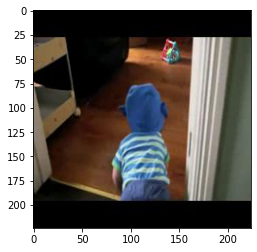

In [41]:
plt.imshow(images[0,0].permute(1,2,0).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


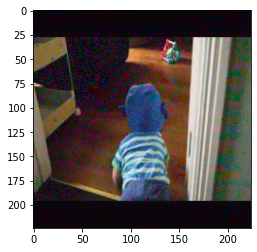

In [40]:
plt.imshow(lrgb2rgb(rgb2lrgb(images)+perturbation)[0,0].permute(1,2,0).cpu())

In [16]:
(images[0] - lrgb2rgb(rgb2lrgb(images[0]))).abs().mean()

tensor(1.7062e-08, device='cuda:0')

In [22]:
# Define test set
val_dataset = Dataset(
    dataset_path="data/UCF-101-frames/",
    split_path="data/ucfTrainTestlist",
    split_number=1,
    input_shape=(3,224,224),
    sequence_length=40,
    training=False,
)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [53]:
# Check model accuracy
correct = total = 0
idx = 49
model.eval()
# model.lstm.train()
torch.backends.cudnn.enabled=True

with torch.no_grad():
    X, y =  val_dataset.__getitem__(idx)
    image_sequences = Variable(X.unsqueeze(0).to(device), requires_grad=False)
    labels = Variable(torch.tensor(y), requires_grad=False).to(device)
    with torch.no_grad():
        # Reset LSTM hidden state
        model.lstm.reset_hidden_state()
        # Get sequence predictions
        predictions = model(image_sequences)
        loss = 0
        # Update loss and prediction histogram at each timestep

    # Compute accuracy using the most common prediction for each sequence
    # Keep track of accuracy
    _, pred = predictions.max(1)
    correct += pred.eq(labels).sum().item()
    total += pred.shape[0]
    # Log test performance
    print(
        "\rTesting -- [Batch %d/%d], Acc: %.2f%%"
        % (idx, len(val_dataloader), correct/total)
        , end='\n'
    )
    print (pred, y)

Testing -- [Batch 49/237], Acc: 1.00%
tensor([1], device='cuda:0') 1


In [23]:
# Check model accuracy
correct = total = 0
idx = 2513
model.eval()
model.lstm.train()
torch.backends.cudnn.enabled=True

with torch.no_grad():
    # for idx in range(3783):
    for idx, (X, y) in enumerate(val_dataloader):
    #     X, y =  val_dataset.__getitem__(idx))
        image_sequences = Variable(X.to(device), requires_grad=False)
        labels = Variable(torch.tensor(y), requires_grad=False).to(device)
        with torch.no_grad():
            # Reset LSTM hidden state
            model.lstm.reset_hidden_state()
            # Get sequence predictions
            predictions = model(image_sequences)
            loss = 0
            # Update loss and prediction histogram at each timestep

        # Compute accuracy using the most common prediction for each sequence
        # Keep track of accuracy
        _, pred = predictions.max(1)
        correct += pred.eq(labels).sum().item()
        total += pred.shape[0]
        # Log test performance
        print(
            "\rTesting -- [Batch %d/%d], Acc: %.2f%%"
            % (idx, len(val_dataloader), correct/total)
            , end='\n'
        )
        print (pred, y)

/home/sangwooji/miniconda3/envs/colorfusion/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Testing -- [Batch 0/237], Acc: 0.00%
tensor([33, 77, 77, 33, 33, 33, 77, 77, 33,  1,  1,  1,  1,  1,  1,  1],
       device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Testing -- [Batch 1/237], Acc: 0.31%
tensor([ 0, 77, 99,  0,  1,  1,  0,  0,  0,  0,  0, 33,  0,  1,  0,  0],
       device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Testing -- [Batch 2/237], Acc: 0.46%
tensor([ 0,  0,  0,  0,  0, 77,  0,  0,  0,  0,  1,  1, 19,  1,  1,  1],
       device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])
Testing -- [Batch 3/237], Acc: 0.59%
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


KeyboardInterrupt: 

In [24]:
# Check model accuracy
correct = total = 0
idx = 2513
model.eval()
# model.lstm.train()
torch.backends.cudnn.enabled=True

with torch.no_grad():
    # for idx in range(3783):
    for idx, (X, y) in enumerate(val_dataloader):
    #     X, y =  val_dataset.__getitem__(idx))
        image_sequences = Variable(X.to(device), requires_grad=False)
        labels = Variable(torch.tensor(y), requires_grad=False).to(device)
        with torch.no_grad():
            # Reset LSTM hidden state
            model.lstm.reset_hidden_state()
            # Get sequence predictions
            predictions = model(image_sequences)
            loss = 0
            # Update loss and prediction histogram at each timestep

        # Compute accuracy using the most common prediction for each sequence
        # Keep track of accuracy
        _, pred = predictions.max(1)
        correct += pred.eq(labels).sum().item()
        total += pred.shape[0]
        # Log test performance
        print(
            "\rTesting -- [Batch %d/%d], Acc: %.2f%%"
            % (idx, len(val_dataloader), correct/total)
            , end='\n'
        )
        print (pred, y)

/home/sangwooji/miniconda3/envs/colorfusion/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Testing -- [Batch 0/237], Acc: 0.00%
tensor([33, 77, 77, 33, 33, 33, 77, 77, 33,  1,  1,  1,  1,  1,  1,  1],
       device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Testing -- [Batch 1/237], Acc: 0.31%
tensor([ 0, 77, 99,  0,  1,  1,  0,  0,  0,  0,  0, 33,  0,  1,  0,  0],
       device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Testing -- [Batch 2/237], Acc: 0.46%
tensor([ 0,  0,  0,  0,  0, 77,  0,  0,  0,  0,  1,  1, 19,  1,  1,  1],
       device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])
Testing -- [Batch 3/237], Acc: 0.59%
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


KeyboardInterrupt: 